<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f846d30b5e0>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


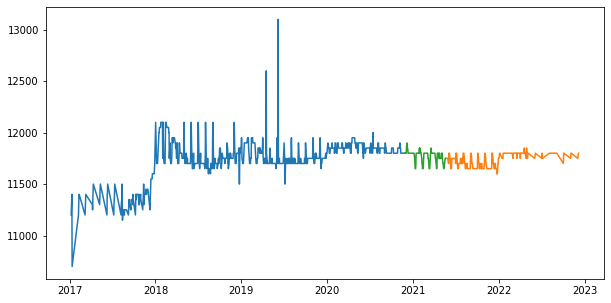

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [12]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [13]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 26s 391ms/step - loss: 0.1728 - mae: 0.4142 - mape: 86.6209 - val_loss: 0.1300 - val_mae: 0.3313 - val_mape: 13230545.0000
Epoch 2/30
44/44 [==============================] - 9s 194ms/step - loss: 0.0963 - mae: 0.3082 - mape: 64.4148 - val_loss: 0.0800 - val_mae: 0.2579 - val_mape: 23843812.0000
Epoch 3/30
44/44 [==============================] - 8s 191ms/step - loss: 0.0509 - mae: 0.2235 - mape: 46.6561 - val_loss: 0.0554 - val_mae: 0.2132 - val_mape: 31617314.0000
Epoch 4/30
44/44 [==============================] - 8s 190ms/step - loss: 0.0269 - mae: 0.1623 - mape: 33.8465 - val_loss: 0.0440 - val_mae: 0.1808 - val_mape: 37302004.0000
Epoch 5/30
44/44 [==============================] - 8s 190ms/step - loss: 0.0140 - mae: 0.1166 - mape: 24.3079 - val_loss: 0.0392 - val_mae: 0.1569 - val_mape: 41474332.0000
Epoch 6/30
44/44 [==============================] - 8s 189ms/step - loss: 0.0073 - mae: 0.0833 - mape: 17.3279 - val_loss: 0.0375

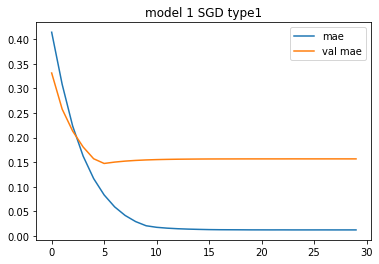

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 24ms/step
95.1367 0.81375873 111.84841251807063


,date,actual,prediction
0,2021-05-20,11750,11842.222656
1,2021-05-21,11750,11842.022461
2,2021-05-24,11750,11841.927734
3,2021-05-25,11750,11841.561523
4,2021-05-27,11750,11841.323242
...,...,...,...
229,2022-11-02,11800,11836.847656
230,2022-11-03,11800,11836.338867
231,2022-11-04,11800,11836.557617
232,2022-12-01,11750,11836.167969


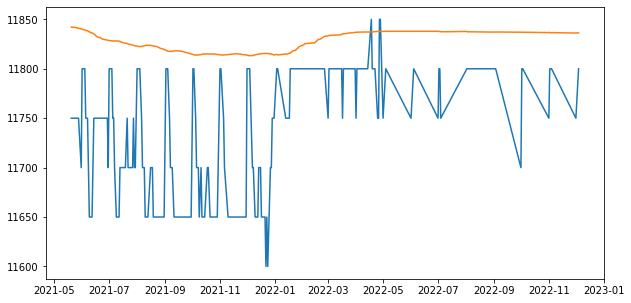

In [ ]:
prediction = forecast_predict(model, test_beras_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras = pd.DataFrame()
data_new_beras['date'] = y_test
data_new_beras['actual'] = x_test
data_new_beras['prediction'] = data_result
data_new_beras.to_csv('beras_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras.date, data_new_beras.actual)
plt.plot(data_new_beras.date, data_new_beras.prediction)
data_new_beras

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 34s 48ms/step - loss: 0.0022 - mae: 0.0338 - mape: 7.2426 - val_loss: 0.0391 - val_mae: 0.1554 - val_mape: 50989432.0000
Epoch 2/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0023 - mae: 0.0334 - mape: 7.1296 - val_loss: 0.0392 - val_mae: 0.1555 - val_mape: 51111468.0000
Epoch 3/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0023 - mae: 0.0330 - mape: 7.0191 - val_loss: 0.0392 - val_mae: 0.1556 - val_mape: 51149392.0000
Epoch 4/30
718/718 [==============================] - 30s 41ms/step - loss: 0.0023 - mae: 0.0336 - mape: 7.1649 - val_loss: 0.0391 - val_mae: 0.1554 - val_mape: 51040588.0000
Epoch 5/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0023 - mae: 0.0336 - mape: 7.1789 - val_loss: 0.0392 - val_mae: 0.1556 - val_mape: 51159456.0000
Epoch 6/30
718/718 [==============================] - 26s 37ms/step - loss: 0.0022 - mae: 0.0331 - mape: 7.0633 - val_loss: 0

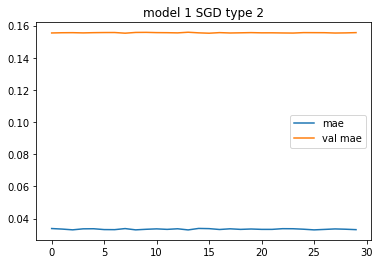

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 7ms/step
76.71376 0.6566135 95.70007265540606


,date,actual,prediction
0,2021-05-20,11750,11842.222656
1,2021-05-21,11750,11842.022461
2,2021-05-24,11750,11841.927734
3,2021-05-25,11750,11841.561523
4,2021-05-27,11750,11841.323242
...,...,...,...
229,2022-11-02,11800,11836.847656
230,2022-11-03,11800,11836.338867
231,2022-11-04,11800,11836.557617
232,2022-12-01,11750,11836.167969


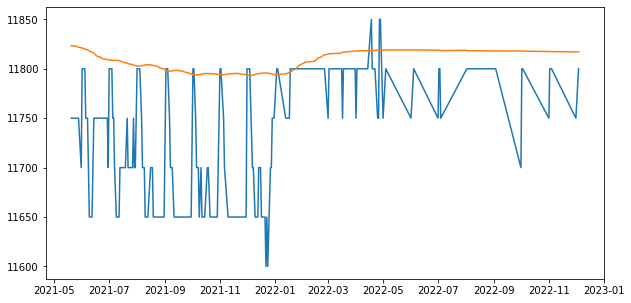

In [ ]:
win_size1 = 60
test_beras_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_1 = pd.DataFrame()
data_new_beras_1['actual'] = x_test
data_new_beras_1['prediction'] = data_result_1
data_new_beras_1.to_csv('beras_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_1.actual)
plt.plot(y_test, data_new_beras_1.prediction)
data_new_beras

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0018 - mae: 0.0265 - mape: 5.7082 - val_loss: 0.0390 - val_mae: 0.1551 - val_mape: 50828328.0000
Epoch 2/30
84/84 [==============================] - 11s 133ms/step - loss: 0.0018 - mae: 0.0261 - mape: 5.5873 - val_loss: 0.0388 - val_mae: 0.1549 - val_mape: 50623116.0000
Epoch 3/30
84/84 [==============================] - 11s 128ms/step - loss: 0.0018 - mae: 0.0259 - mape: 5.5413 - val_loss: 0.0387 - val_mae: 0.1547 - val_mape: 50512396.0000
Epoch 4/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0018 - mae: 0.0258 - mape: 5.5078 - val_loss: 0.0387 - val_mae: 0.1547 - val_mape: 50451080.0000
Epoch 5/30
84/84 [==============================] - 11s 128ms/step - loss: 0.0018 - mae: 0.0257 - mape: 5.4742 - val_loss: 0.0387 - val_mae: 0.1546 - val_mape: 50423664.0000
Epoch 6/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0018 - mae: 0.0258 - mape: 5.4906 - val_loss: 0.0387 

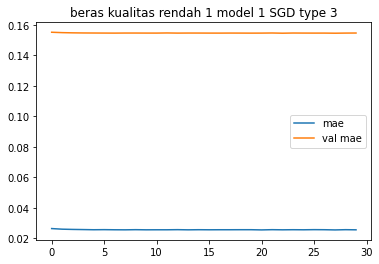

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 12ms/step
64.29605 0.55047566 82.61222835293513


,actual,prediction
0,11750,11805.860352
1,11750,11805.657227
2,11750,11805.510742
3,11750,11805.127930
4,11750,11804.828125
...,...,...
229,11800,11800.194336
230,11800,11799.683594
231,11800,11799.884766
232,11750,11799.507812


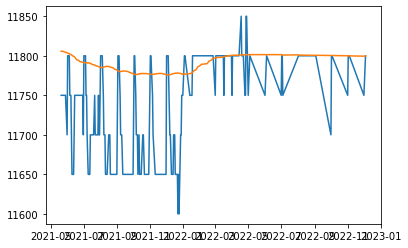

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_2['actual'] = x_test
data_new_beras_2['prediction'] = data_result_2
data_new_beras_2.to_csv('beras_model1_sgd_type3')

plt.plot(y_test, data_new_beras_2.actual)
plt.plot(y_test, data_new_beras_2.prediction)
data_new_beras_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 14s 221ms/step - loss: 0.1510 - mae: 0.3864 - mape: 80.7419 - val_loss: 0.1124 - val_mae: 0.3076 - val_mape: 16749869.0000
Epoch 2/30
44/44 [==============================] - 9s 198ms/step - loss: 0.0650 - mae: 0.2498 - mape: 52.1753 - val_loss: 0.0487 - val_mae: 0.1962 - val_mape: 34970356.0000
Epoch 3/30
44/44 [==============================] - 9s 196ms/step - loss: 0.0066 - mae: 0.0625 - mape: 12.9417 - val_loss: 0.0405 - val_mae: 0.1569 - val_mape: 52455272.0000
Epoch 4/30
44/44 [==============================] - 9s 197ms/step - loss: 3.0825e-04 - mae: 0.0138 - mape: 2.9107 - val_loss: 0.0391 - val_mae: 0.1551 - val_mape: 50978188.0000
Epoch 5/30
44/44 [==============================] - 9s 197ms/step - loss: 3.2074e-04 - mae: 0.0140 - mape: 2.9187 - val_loss: 0.0391 - val_mae: 0.1551 - val_mape: 50992448.0000
Epoch 6/30
44/44 [==============================] - 9s 197ms/step - loss: 3.1082e-04 - mae: 0.0139 - mape: 2.8894 - val_los

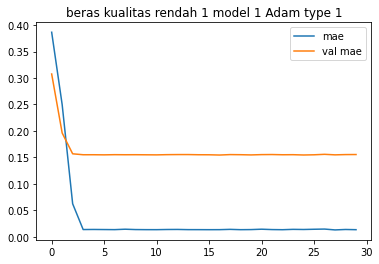

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 25ms/step
61.98238 0.53021246 75.5318641369323


,actual,prediction
0,11750,11827.867188
1,11750,11827.780273
2,11750,11826.923828
3,11750,11826.490234
4,11750,11825.404297
...,...,...
229,11800,11812.358398
230,11800,11812.574219
231,11800,11812.000977
232,11750,11812.247070


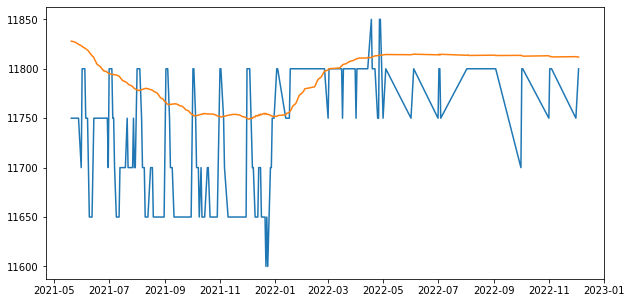

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_a = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a['actual'] = x_test
data_new_beras_a['prediction'] = data_result_a
data_new_beras_a.to_csv('beras_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_a.actual)
plt.plot(y_test, data_new_beras_a.prediction)
data_new_beras_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 28s 39ms/step - loss: 0.0025 - mae: 0.0315 - mape: 6.6655 - val_loss: 0.0399 - val_mae: 0.1558 - val_mape: 51800640.0000
Epoch 2/30
718/718 [==============================] - 26s 37ms/step - loss: 0.0023 - mae: 0.0312 - mape: 6.6154 - val_loss: 0.0397 - val_mae: 0.1555 - val_mape: 51588952.0000
Epoch 3/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0023 - mae: 0.0306 - mape: 6.4652 - val_loss: 0.0407 - val_mae: 0.1569 - val_mape: 52690868.0000
Epoch 4/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0023 - mae: 0.0308 - mape: 6.5351 - val_loss: 0.0397 - val_mae: 0.1555 - val_mape: 51591492.0000
Epoch 5/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0023 - mae: 0.0303 - mape: 6.4185 - val_loss: 0.0398 - val_mae: 0.1555 - val_mape: 51661676.0000
Epoch 6/30
718/718 [==============================] - 26s 37ms/step - loss: 0.0022 - mae: 0.0308 - mape: 6.5285 - val_loss: 0

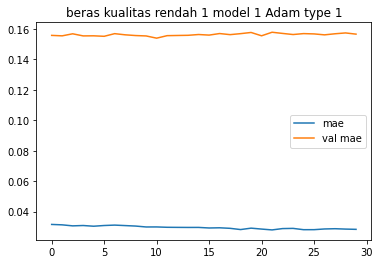

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
119.061195 1.0173707 130.54432317224675


,actual,prediction
0,11750,11884.003906
1,11750,11883.995117
2,11750,11883.262695
3,11750,11882.703125
4,11750,11881.754883
...,...,...
229,11800,11872.078125
230,11800,11871.988281
231,11800,11871.561523
232,11750,11871.675781


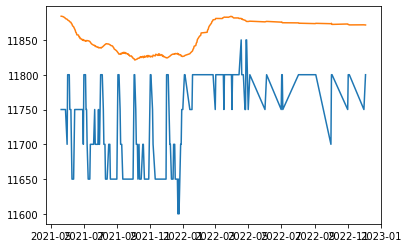

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_a1 = pd.DataFrame()
data_new_beras_a1['actual'] = x_test
data_new_beras_a1['prediction'] = data_result_a1
data_new_beras_a1.to_csv('beras_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_a1.actual)
plt.plot(y_test, data_new_beras_a1.prediction)
data_new_beras_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0017 - mae: 0.0235 - mape: 4.9937 - val_loss: 0.0392 - val_mae: 0.1552 - val_mape: 50830396.0000
Epoch 2/30
84/84 [==============================] - 11s 134ms/step - loss: 0.0017 - mae: 0.0223 - mape: 4.6731 - val_loss: 0.0403 - val_mae: 0.1568 - val_mape: 52212824.0000
Epoch 3/30
84/84 [==============================] - 11s 132ms/step - loss: 0.0016 - mae: 0.0222 - mape: 4.6996 - val_loss: 0.0391 - val_mae: 0.1551 - val_mape: 50781428.0000
Epoch 4/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0016 - mae: 0.0218 - mape: 4.5841 - val_loss: 0.0404 - val_mae: 0.1569 - val_mape: 52241864.0000
Epoch 5/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0016 - mae: 0.0213 - mape: 4.4820 - val_loss: 0.0399 - val_mae: 0.1563 - val_mape: 51747028.0000
Epoch 6/30
84/84 [==============================] - 11s 131ms/step - loss: 0.0017 - mae: 0.0212 - mape: 4.4505 - val_loss: 0.0398 

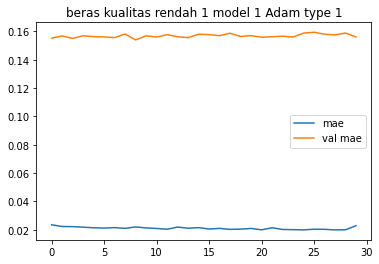

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
38.390343 0.32733756 48.76707683676688


,actual,prediction
0,11750,11781.577148
1,11750,11781.146484
2,11750,11780.518555
3,11750,11779.442383
4,11750,11778.600586
...,...,...
229,11800,11781.669922
230,11800,11780.741211
231,11800,11779.769531
232,11750,11779.041016


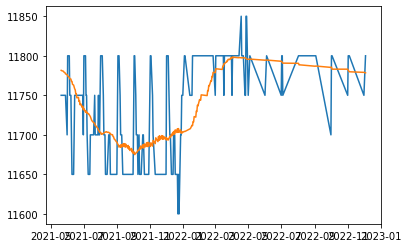

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_a2 = pd.DataFrame()
# data_new_beras1['date'] = date_test
data_new_beras_a2['actual'] = x_test
data_new_beras_a2['prediction'] = data_result_a2
data_new_beras_a2.to_csv('beras_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_a2.actual)
plt.plot(y_test, data_new_beras_a2.prediction)
data_new_beras_a2

## model 1

### Adam

In [9]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 349ms/step - loss: 0.1463 - mae: 0.3697 - mape: 77.1766 - val_loss: 0.0372 - val_mae: 0.1462 - val_mape: 44078024.0000
Epoch 2/15
44/44 [==============================] - 15s 331ms/step - loss: 0.0030 - mae: 0.0409 - mape: 8.5595 - val_loss: 0.0390 - val_mae: 0.1549 - val_mape: 51138392.0000
Epoch 3/15
44/44 [==============================] - 14s 325ms/step - loss: 3.3486e-04 - mae: 0.0145 - mape: 3.0242 - val_loss: 0.0390 - val_mae: 0.1549 - val_mape: 51055900.0000
Epoch 4/15
44/44 [==============================] - 14s 328ms/step - loss: 3.2151e-04 - mae: 0.0143 - mape: 2.9793 - val_loss: 0.0385 - val_mae: 0.1541 - val_mape: 50426536.0000
Epoch 5/15
44/44 [==============================] - 15s 330ms/step - loss: 3.4340e-04 - mae: 0.0150 - mape: 3.1202 - val_loss: 0.0387 - val_mae: 0.1545 - val_mape: 50780040.0000
Epoch 6/15
44/44 [==============================] - 15s 335ms/step - loss: 3.5150e-04 - mae: 0.0154 - mape: 3.2076 - 

17/17 [==============================] - 0s 17ms/step - loss: 0.0678 - mae: 0.2385 - mape: 30.4463


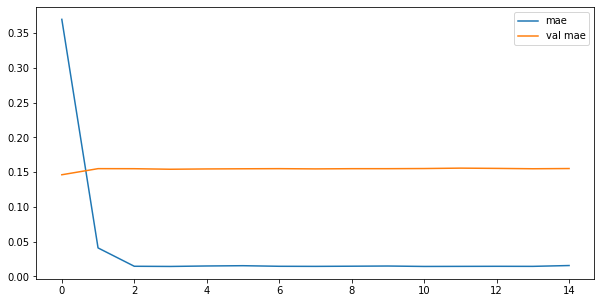

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_beras_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras1 = pd.DataFrame()
data_new_beras1['actual'] = x_test
data_new_beras1['prediction'] = data_result1
data_new_beras1.to_csv('beras_model2_adam_type1.csv')

data_new_beras1

131/131 [==============================] - 6s 35ms/step
60.409134 0.51650727 71.71414405144392


,actual,prediction
0,11750,11768.180664
1,11750,11768.214844
2,11750,11768.117188
3,11750,11768.156250
4,11750,11768.038086
...,...,...
229,11800,11766.150391
230,11800,11766.130859
231,11800,11766.180664
232,11750,11766.149414


In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras1['prediction'], '-o')

#### Type 2

In [14]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 19s 10ms/step - loss: 0.0097 - mae: 0.0494 - mape: 10.4521 - val_loss: 0.0393 - val_mae: 0.1554 - val_mape: 51152396.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0027 - mae: 0.0332 - mape: 7.0199 - val_loss: 0.0406 - val_mae: 0.1572 - val_mape: 52563676.0000
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0025 - mae: 0.0324 - mape: 6.8500 - val_loss: 0.0391 - val_mae: 0.1550 - val_mape: 50934616.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0025 - mae: 0.0328 - mape: 6.9442 - val_loss: 0.0433 - val_mae: 0.1599 - val_mape: 54837920.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0025 - mae: 0.0323 - mape: 6.8328 - val_loss: 0.0395 - val_mae: 0.1556 - val_mape: 51462720.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0024 - mae: 0.0319 - mape: 6.7701 - val_loss: 0.0386 - v

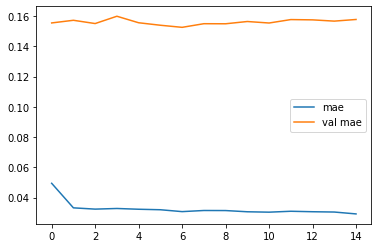

In [15]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 4ms/step
142.8616 1.2203344 152.7759350425485


,actual,prediction
0,11750,11900.297852
1,11750,11901.493164
2,11750,11899.883789
3,11750,11900.970703
4,11750,11898.892578
...,...,...
229,11800,11892.545898
230,11800,11890.488281
231,11800,11891.596680
232,11750,11890.349609


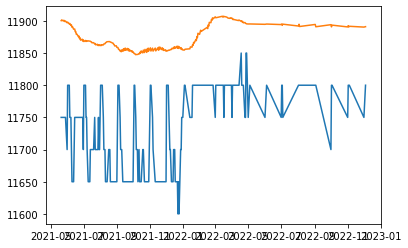

In [16]:
prediction1_1 = forecast_predict(model1, test_beras_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras1_1 = pd.DataFrame()
data_new_beras1_1['actual'] = x_test
data_new_beras1_1['prediction'] = data_result1_1
data_new_beras1_1.to_csv('beras_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras1_1.actual)
plt.plot(y_test, data_new_beras1_1.prediction)
data_new_beras1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 24s 288ms/step - loss: 0.0016 - mae: 0.0213 - mape: 4.4562 - val_loss: 0.0382 - val_mae: 0.1527 - val_mape: 48473024.0000
Epoch 2/15
84/84 [==============================] - 20s 232ms/step - loss: 0.0018 - mae: 0.0250 - mape: 5.2749 - val_loss: 0.0381 - val_mae: 0.1519 - val_mape: 47784360.0000
Epoch 3/15
84/84 [==============================] - 18s 208ms/step - loss: 0.0019 - mae: 0.0244 - mape: 5.1455 - val_loss: 0.0381 - val_mae: 0.1500 - val_mape: 46245092.0000
Epoch 4/15
84/84 [==============================] - 19s 224ms/step - loss: 0.0016 - mae: 0.0215 - mape: 4.5161 - val_loss: 0.0381 - val_mae: 0.1502 - val_mape: 46370760.0000
Epoch 5/15
84/84 [==============================] - 18s 207ms/step - loss: 0.0017 - mae: 0.0231 - mape: 4.8414 - val_loss: 0.0382 - val_mae: 0.1506 - val_mape: 46585320.0000
Epoch 6/15
84/84 [==============================] - 18s 207ms/step - loss: 0.0016 - mae: 0.0220 - mape: 4.6261 - val_loss: 0.0385 

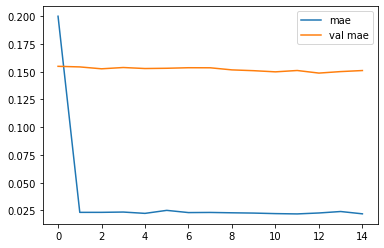

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 4s 15ms/step
63.26461 0.5408103 74.63124842977973


,actual,prediction
0,11750,11840.798828
1,11750,11840.212891
2,11750,11840.227539
3,11750,11839.546875
4,11750,11839.247070
...,...,...
229,11800,11819.436523
230,11800,11820.398438
231,11800,11818.752930
232,11750,11819.997070


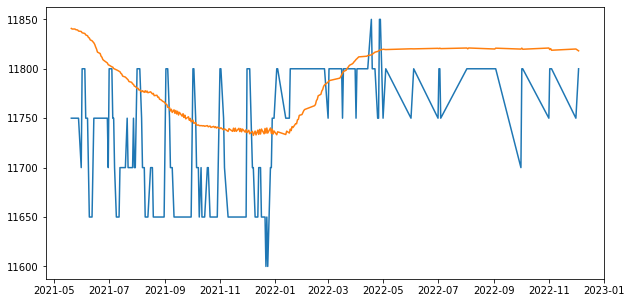

In [ ]:
prediction1_2 = forecast_predict(model1, test_beras_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras1_2 = pd.DataFrame()
data_new_beras1_2['actual'] = x_test
data_new_beras1_2['prediction'] = data_result1_2
data_new_beras1_2.to_csv('beras_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_2.actual)
plt.plot(y_test, data_new_beras1_2.prediction)

data_new_beras1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_8 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_9 (LSTM)               (None, 32)                20608     
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 346ms/step - loss: 0.1997 - mae: 0.4456 - mape: 93.2076 - val_loss: 0.1553 - val_mae: 0.3618 - val_mape: 8938582.0000
Epoch 2/15
44/44 [==============================] - 14s 325ms/step - loss: 0.1269 - mae: 0.3547 - mape: 74.1436 - val_loss: 0.1060 - val_mae: 0.2981 - val_mape: 17747910.0000
Epoch 3/15
44/44 [==============================] - 14s 322ms/step - loss: 0.0802 - mae: 0.2819 - mape: 58.8941 - val_loss: 0.0763 - val_mae: 0.2522 - val_mape: 24744894.0000
Epoch 4/15
44/44 [==============================] - 14s 317ms/step - loss: 0.0505 - mae: 0.2235 - mape: 46.6859 - val_loss: 0.0585 - val_mae: 0.2201 - val_mape: 30379924.0000
Epoch 5/15
44/44 [==============================] - 14s 321ms/step - loss: 0.0316 - mae: 0.1762 - mape: 36.7802 - val_loss: 0.0479 - val_mae: 0.1938 - val_mape: 34961476.0000
Epoch 6/15
44/44 [==============================] - 14s 319ms/step - loss: 0.0195 - mae: 0.1382 - mape: 28.8084 - val_loss: 0.

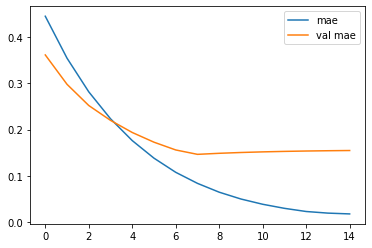

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 34ms/step
60.729668 0.5193097 72.62651273166364


,actual,prediction
0,11750,11766.409180
1,11750,11766.444336
2,11750,11766.398438
3,11750,11766.432617
4,11750,11766.384766
...,...,...
229,11800,11766.163086
230,11800,11766.089844
231,11800,11766.128906
232,11750,11766.092773


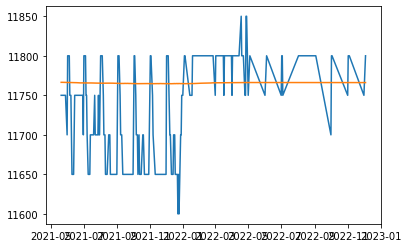

In [ ]:
prediction1_a = forecast_predict(model1_a, test_beras_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras1_a = pd.DataFrame()
data_new_beras1_a['actual'] = x_test
data_new_beras1_a['prediction'] = data_result1_a
data_new_beras1_a.to_csv('beras_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras1_a.actual)
plt.plot(y_test, data_new_beras1_a.prediction)

data_new_beras1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0023 - mae: 0.0342 - mape: 7.3043 - val_loss: 0.0388 - val_mae: 0.1549 - val_mape: 50567436.0000
Epoch 2/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0023 - mae: 0.0338 - mape: 7.2065 - val_loss: 0.0389 - val_mae: 0.1550 - val_mape: 50728624.0000
Epoch 3/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0023 - mae: 0.0343 - mape: 7.3173 - val_loss: 0.0389 - val_mae: 0.1550 - val_mape: 50728684.0000
Epoch 4/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0023 - mae: 0.0343 - mape: 7.3362 - val_loss: 0.0388 - val_mae: 0.1549 - val_mape: 50585956.0000
Epoch 5/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0023 - mae: 0.0337 - mape: 7.1700 - val_loss: 0.0390 - val_mae: 0.1552 - val_mape: 50845544.0000
Epoch 6/15
718/718 [==============================] - 31s 43ms/step - loss: 0.0023 - mae: 0.0342 - mape: 7.3181 - val_loss: 0

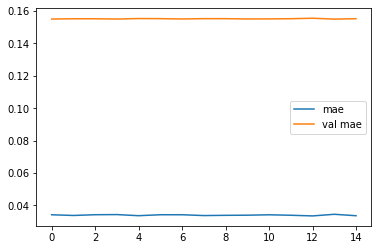

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
60.804413 0.51996124 72.78150158286273


,actual,prediction
0,11750,11766.847656
1,11750,11766.883789
2,11750,11766.815430
3,11750,11766.853516
4,11750,11766.780273
...,...,...
229,11800,11766.552734
230,11800,11766.486328
231,11800,11766.520508
232,11750,11766.491211


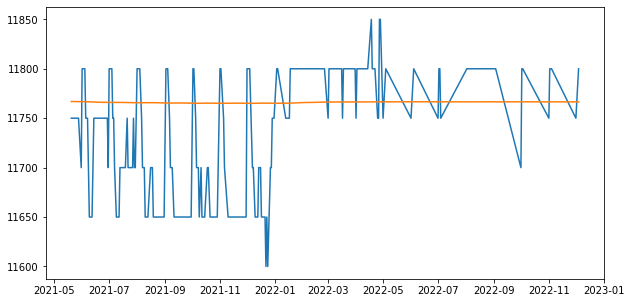

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_beras_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras1_a1 = pd.DataFrame()
data_new_beras1_a1['actual'] = x_test
data_new_beras1_a1['prediction'] = data_result1_a1
data_new_beras1_a1.to_csv('beras_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a1.actual)
plt.plot(y_test, data_new_beras1_a1.prediction)
data_new_beras1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0019 - mae: 0.0274 - mape: 5.9269 - val_loss: 0.0387 - val_mae: 0.1546 - val_mape: 50444552.0000
Epoch 2/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0019 - mae: 0.0269 - mape: 5.7787 - val_loss: 0.0385 - val_mae: 0.1543 - val_mape: 50166896.0000
Epoch 3/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0018 - mae: 0.0269 - mape: 5.7587 - val_loss: 0.0384 - val_mae: 0.1542 - val_mape: 50094836.0000
Epoch 4/15
84/84 [==============================] - 18s 216ms/step - loss: 0.0018 - mae: 0.0266 - mape: 5.6683 - val_loss: 0.0384 - val_mae: 0.1541 - val_mape: 49989812.0000
Epoch 5/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0018 - mae: 0.0266 - mape: 5.6595 - val_loss: 0.0383 - val_mae: 0.1541 - val_mape: 49976112.0000
Epoch 6/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0018 - mae: 0.0267 - mape: 5.6889 - val_loss: 0.0384 

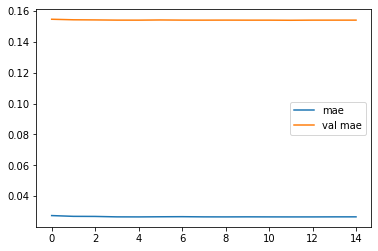

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 16ms/step
60.27283 0.5153619 71.90659971123131


,actual,prediction
0,11750,11765.014648
1,11750,11765.050781
2,11750,11764.982422
3,11750,11765.020508
4,11750,11764.948242
...,...,...
229,11800,11764.719727
230,11800,11764.653320
231,11800,11764.687500
232,11750,11764.658203


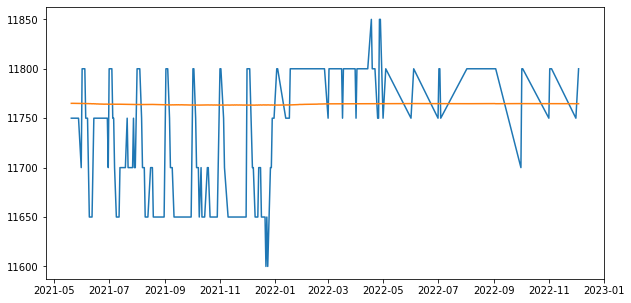

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_beras_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras1_a2 = pd.DataFrame()
data_new_beras1_a2['actual'] = x_test
data_new_beras1_a2['prediction'] = data_result1_a2
data_new_beras1_a2.to_csv('beras_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras1_a2.actual)
plt.plot(y_test, data_new_beras1_a2.prediction)

data_new_beras1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_10 (LSTM)              (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                20224     
                                                                 
 dense_13 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 137ms/step - loss: 0.1981 - mae: 0.4443 - mape: 92.9421 - val_loss: 0.1626 - val_mae: 0.3700 - val_mape: 7875705.0000
Epoch 2/50
44/44 [==============================] - 5s 113ms/step - loss: 0.1400 - mae: 0.3732 - mape: 78.0245 - val_loss: 0.1184 - val_mae: 0.3158 - val_mape: 15357904.0000
Epoch 3/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0966 - mae: 0.3098 - mape: 64.7526 - val_loss: 0.0885 - val_mae: 0.2701 - val_mape: 21668102.0000
Epoch 4/50
44/44 [==============================] - 5s 113ms/step - loss: 0.0665 - mae: 0.2567 - mape: 53.6416 - val_loss: 0.0687 - val_mae: 0.2397 - val_mape: 26966964.0000
Epoch 5/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0454 - mae: 0.2117 - mape: 44.2115 - val_loss: 0.0557 - val_mae: 0.2139 - val_mape: 31440028.0000
Epoch 6/50
44/44 [==============================] - 5s 114ms/step - loss: 0.0307 - mae: 0.1739 - mape: 36.2881 - val_loss: 0.0475 

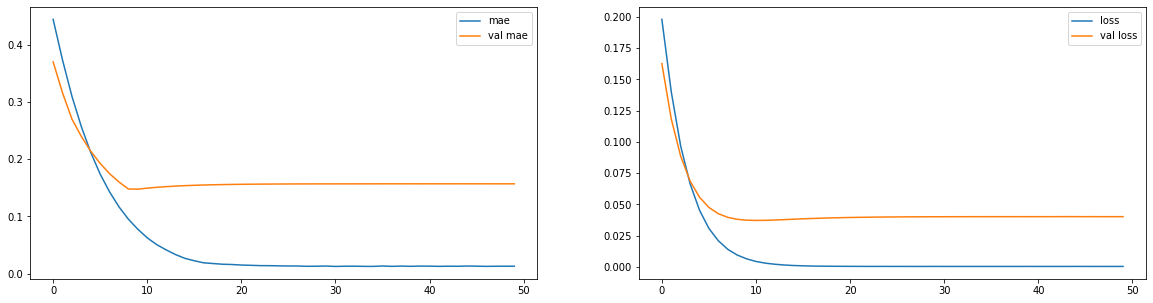

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 16ms/step
61.963856 0.5299744 74.71597587384676


,actual,prediction
0,11750,11769.573242
1,11750,11769.575195
2,11750,11769.561523
3,11750,11769.560547
4,11750,11769.560547
...,...,...
229,11800,11769.490234
230,11800,11769.477539
231,11800,11769.481445
232,11750,11769.489258


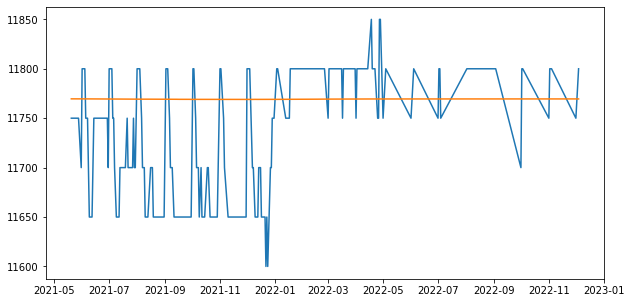

In [ ]:
prediction2 = forecast_predict(model2, test_beras_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras2 = pd.DataFrame()
data_new_beras2['actual'] = x_test
data_new_beras2['prediction'] = data_result2
data_new_beras2.to_csv('beras_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras2.actual)
plt.plot(y_test, data_new_beras2.prediction)
data_new_beras2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0024 - mae: 0.0363 - mape: 7.8484 - val_loss: 0.0389 - val_mae: 0.1553 - val_mape: 50763000.0000
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0024 - mae: 0.0354 - mape: 7.5771 - val_loss: 0.0389 - val_mae: 0.1553 - val_mape: 50723116.0000
Epoch 3/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0023 - mae: 0.0351 - mape: 7.5086 - val_loss: 0.0390 - val_mae: 0.1554 - val_mape: 50859236.0000
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0024 - mae: 0.0355 - mape: 7.6065 - val_loss: 0.0389 - val_mae: 0.1552 - val_mape: 50681116.0000
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0024 - mae: 0.0354 - mape: 7.5520 - val_loss: 0.0390 - val_mae: 0.1555 - val_mape: 50881592.0000
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0024 - mae: 0.0354 - mape: 7.5632 - val_loss: 0

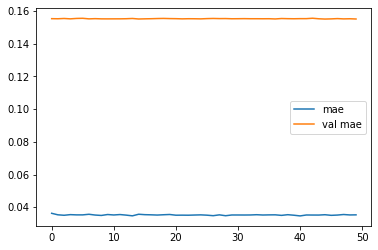

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_beras_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras2_1 = pd.DataFrame()
data_new_beras2_1['actual'] = x_test
data_new_beras2_1['prediction'] = data_result2_1
data_new_beras2_1.to_csv('beras_model3_sgd_type2.csv')

data_new_beras2

199/199 [==============================] - 1s 5ms/step
60.878548 0.5205848 72.84550955082098


,actual,prediction
0,11750,11769.573242
1,11750,11769.575195
2,11750,11769.561523
3,11750,11769.560547
4,11750,11769.560547
...,...,...
229,11800,11769.490234
230,11800,11769.477539
231,11800,11769.481445
232,11750,11769.489258


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0019 - mae: 0.0281 - mape: 6.0486 - val_loss: 0.0387 - val_mae: 0.1550 - val_mape: 50522460.0000
Epoch 2/50
84/84 [==============================] - 7s 77ms/step - loss: 0.0019 - mae: 0.0280 - mape: 6.0122 - val_loss: 0.0386 - val_mae: 0.1548 - val_mape: 50409452.0000
Epoch 3/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0019 - mae: 0.0278 - mape: 5.9487 - val_loss: 0.0386 - val_mae: 0.1548 - val_mape: 50365848.0000
Epoch 4/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0019 - mae: 0.0279 - mape: 5.9632 - val_loss: 0.0386 - val_mae: 0.1547 - val_mape: 50315372.0000
Epoch 5/50
84/84 [==============================] - 7s 78ms/step - loss: 0.0019 - mae: 0.0278 - mape: 5.9457 - val_loss: 0.0385 - val_mae: 0.1547 - val_mape: 50276040.0000
Epoch 6/50
84/84 [==============================] - 7s 79ms/step - loss: 0.0019 - mae: 0.0278 - mape: 5.9430 - val_loss: 0.0385 - val_mae: 0

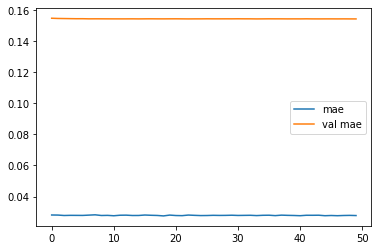

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_beras_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras2_2 = pd.DataFrame()
data_new_beras2_2['actual'] = x_test
data_new_beras2_2['prediction'] = data_result2_2
data_new_beras2_2.to_csv('beras_model3_sgd-type3.csv')

data_new_beras2_2

181/181 [==============================] - 2s 8ms/step
60.556133 0.51779604 72.32176029189797


,actual,prediction
0,11750,11764.699219
1,11750,11764.699219
2,11750,11764.697266
3,11750,11764.696289
4,11750,11764.674805
...,...,...
229,11800,11764.615234
230,11800,11764.634766
231,11800,11764.636719
232,11750,11764.615234


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 146ms/step - loss: 0.1285 - mae: 0.3485 - mape: 72.8039 - val_loss: 0.0523 - val_mae: 0.2063 - val_mape: 32807006.0000
Epoch 2/50
44/44 [==============================] - 6s 138ms/step - loss: 0.0055 - mae: 0.0560 - mape: 11.6614 - val_loss: 0.0370 - val_mae: 0.1491 - val_mape: 46866392.0000
Epoch 3/50
44/44 [==============================] - 6s 126ms/step - loss: 0.0012 - mae: 0.0274 - mape: 5.7170 - val_loss: 0.0374 - val_mae: 0.1511 - val_mape: 48516932.0000
Epoch 4/50
44/44 [==============================] - 6s 127ms/step - loss: 0.0010 - mae: 0.0248 - mape: 5.1718 - val_loss: 0.0380 - val_mae: 0.1525 - val_mape: 49697344.0000
Epoch 5/50
44/44 [==============================] - 6s 128ms/step - loss: 8.4869e-04 - mae: 0.0233 - mape: 4.8652 - val_loss: 0.0376 - val_mae: 0.1517 - val_mape: 49023228.0000
Epoch 6/50
44/44 [==============================] - 6s 127ms/step - loss: 8.9966e-04 - mae: 0.0240 - mape: 5.0140 - val_loss: 0.

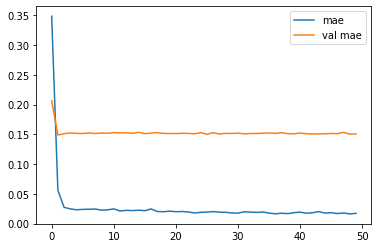

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_beras_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras2_a = pd.DataFrame()
data_new_beras2_a['actual'] = x_test
data_new_beras2_a['prediction'] = data_result2_a
data_new_beras2_a.to_csv('beras_model3_adam-type1.csv')

data_new_beras2_a

131/131 [==============================] - 3s 16ms/step
60.198685 0.5146674 71.32846898876528


,actual,prediction
0,11750,11766.363281
1,11750,11766.333008
2,11750,11766.344727
3,11750,11766.255859
4,11750,11766.244141
...,...,...
229,11800,11764.129883
230,11800,11764.146484
231,11800,11764.220703
232,11750,11764.238281


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 17s 23ms/step - loss: 0.0029 - mae: 0.0356 - mape: 7.5362 - val_loss: 0.0394 - val_mae: 0.1553 - val_mape: 51465520.0000
Epoch 2/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0027 - mae: 0.0351 - mape: 7.4381 - val_loss: 0.0411 - val_mae: 0.1574 - val_mape: 53138300.0000
Epoch 3/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0025 - mae: 0.0335 - mape: 7.1236 - val_loss: 0.0391 - val_mae: 0.1549 - val_mape: 51049236.0000
Epoch 4/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0025 - mae: 0.0333 - mape: 7.0747 - val_loss: 0.0399 - val_mae: 0.1561 - val_mape: 52022700.0000
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0024 - mae: 0.0316 - mape: 6.6891 - val_loss: 0.0390 - val_mae: 0.1548 - val_mape: 50978636.0000
Epoch 6/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0023 - mae: 0.0319 - mape: 6.7814 - val_loss: 0

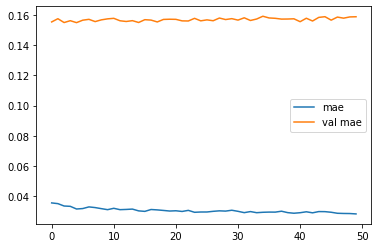

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
61.949726 0.5299163 75.04482709833337


,actual,prediction
0,11750,11773.678711
1,11750,11773.580078
2,11750,11773.700195
3,11750,11773.626953
4,11750,11773.603516
...,...,...
229,11800,11772.852539
230,11800,11772.813477
231,11800,11772.936523
232,11750,11772.919922


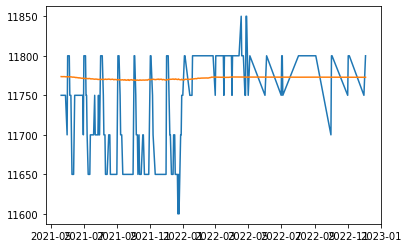

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_beras_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras2_a1 = pd.DataFrame()
data_new_beras2_a1['actual'] = x_test
data_new_beras2_a1['prediction'] = data_result2_a1
data_new_beras2_a1.to_csv('beras_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras2_a1.actual)
plt.plot(y_test, data_new_beras2_a1.prediction)
data_new_beras2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0018 - mae: 0.0251 - mape: 5.3575 - val_loss: 0.0407 - val_mae: 0.1576 - val_mape: 52569924.0000
Epoch 2/50
84/84 [==============================] - 7s 85ms/step - loss: 0.0017 - mae: 0.0238 - mape: 5.0423 - val_loss: 0.0402 - val_mae: 0.1570 - val_mape: 52037544.0000
Epoch 3/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0017 - mae: 0.0241 - mape: 5.1015 - val_loss: 0.0416 - val_mae: 0.1585 - val_mape: 53352596.0000
Epoch 4/50
84/84 [==============================] - 7s 83ms/step - loss: 0.0018 - mae: 0.0243 - mape: 5.1582 - val_loss: 0.0410 - val_mae: 0.1579 - val_mape: 52787700.0000
Epoch 5/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0017 - mae: 0.0236 - mape: 5.0005 - val_loss: 0.0422 - val_mae: 0.1591 - val_mape: 53822384.0000
Epoch 6/50
84/84 [==============================] - 7s 84ms/step - loss: 0.0017 - mae: 0.0233 - mape: 4.9237 - val_loss: 0.0412 - val_mae: 0

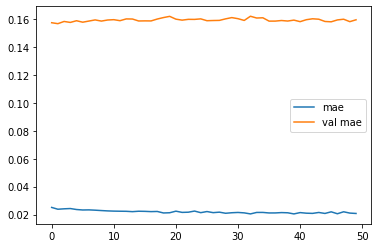

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
56.94917 0.48682845 67.48918460807258


,actual,prediction
0,11750,11762.267578
1,11750,11762.116211
2,11750,11762.207031
3,11750,11762.046875
4,11750,11762.032227
...,...,...
229,11800,11767.469727
230,11800,11767.389648
231,11800,11767.151367
232,11750,11767.180664


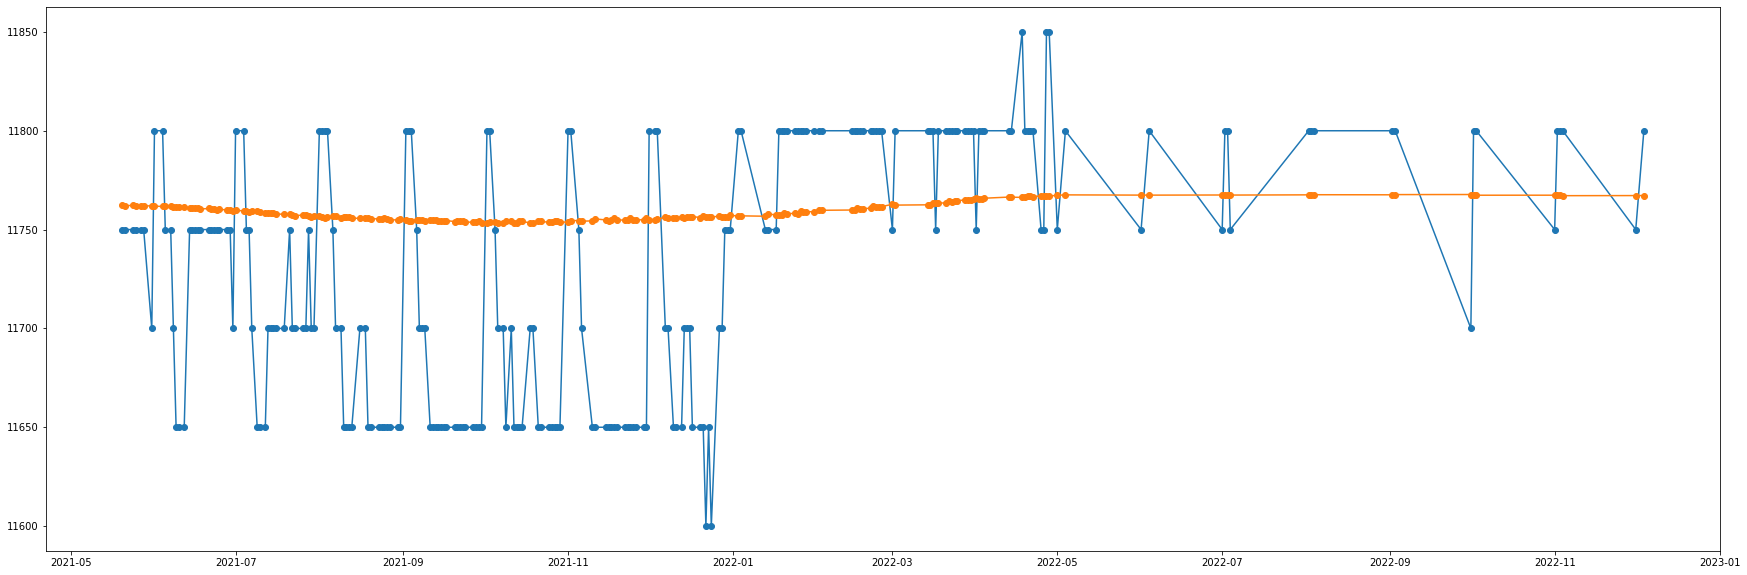

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_beras_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras2_a2 = pd.DataFrame()
data_new_beras2_a2['actual'] = x_test
data_new_beras2_a2['prediction'] = data_result2_a2
data_new_beras2_a2.to_csv('beras_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras2_a2.actual, '-o')
plt.plot(y_test,data_new_beras2_a2.prediction, '-o')
data_new_beras2_a2